# Exercise 5

- write code in modular, re-usable way

## Question 1: Cell and Verlet Lists

- key prerequisite to evaluate Particle-Particle interactions is fast access to neighboring particles 

### 1.a) Implement first a routine that creates cell lists from a set of particles in 1D/2D without symmetry.

For the analysis, each particle needs:
- position (1D, 2D, 3D)
- weights (how much baggage is it carrying)
- sometimes volume

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Generate 10000 particles in a grig from 0 to 1 in 2D grid of 0.05 length
n_particles = 10000
dims = 2
particle_pos = np.random.rand(n_particles, dims)
lower_bounds = np.array([0.0, 0.0])
upper_bounds = np.array([1.0, 1.0])
cell_side = 0.05 # cell side length --> 20 cells in each dimension  

__Cell List__: 
- each cell maintains list of its occupants
- construction of these lists for N particles is O(N)


In [20]:
def create_cell_list(particle_pos, lower_bounds, upper_bounds, cell_side):
    '''
    This function creates a cell list
    '''

    # set up grid
    n_particles, dims = particle_pos.shape # columns, rows
    num_cells = np.ceil((upper_bounds - lower_bounds) / cell_side).astype(int) # number of cells in each dimension

    # create particle matrix
    particle_matrix = np.zeros((n_particles, dims + 1), dtype=int)
    particle_matrix[:, :dims] = particle_pos # first 2 columns are the particle positions in 2D
    cell_list = [[] for _ in range(np.prod(num_cells))] # create a list of empty lists

    # assign particles to cells
    for i in range(n_particles):

        # find the cell index for each particle
        # floor needs to be used because the cell index is 0-based
        cell_index = np.floor((particle_pos[i] - lower_bounds) / cell_side).astype(int)

        # convert the cell index to a single index
        cell_list_index = np.ravel_multi_index(cell_index, dims=num_cells)

        # add the particle to the cell list
        particle_matrix[i, dims] = len(cell_list[cell_list_index])
        cell_list[cell_list_index].append(i)

        # store cell assignment in final column of particle matrix
        particle_matrix[i, dims] = cell_list_index
    return particle_matrix, cell_list, num_cells #particle matrix contains x, y, cell


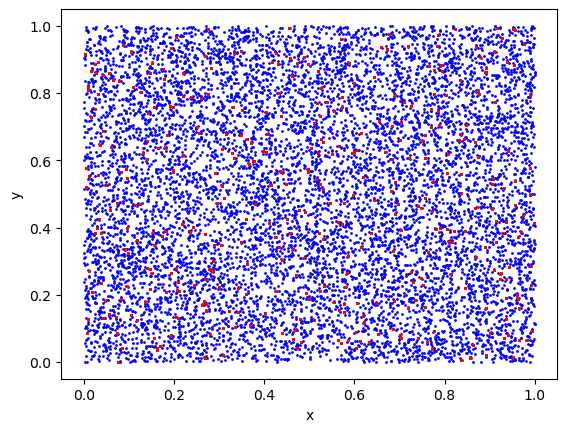

In [35]:
cell_list = create_cell_list(particle_pos, lower_bounds, upper_bounds, cell_side)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)

# plot all particles in blue
ax.scatter(particle_pos[:, 0], particle_pos[:, 1], color='blue', s=1)

# plot one cell in cell_list in red
cell = cell_list[0]
ax.scatter(particle_pos[cell, 0], particle_pos[cell, 1], color='red', s=1)


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()




In [5]:
def get_neighboring_cells(cell_index):
    '''
    this function gets neighbors of the numbered cell
    '''
    #get cell index from the cell number
    cell_indices = np.unravel_index(cell_index, dims=num_cells)

    # create empty list to store neighboring cells
    neighboring_cells = []

    # loop over all neighboring cells
    for offset in np.ndindex(3,3):

        # check if the neighboring cell is within the grid
        neighbor_index = tuple(cell_indices[d] + offset[d] - 1 for d in range(dims))

        if all(0 <= neighbor_index[d] < num_cells[d] for d in range(dims)):

            # convert the cell index to a single index
            neighboring_cells.append(np.ravel_multi_index(neighbor_index, dims=num_cells))
            
    return neighboring_cells

### b) Implement a routine that creates Verlet lists for particle distributions in 1D/2D

__Verlet lists__
- reduce interaction overhead by storing an explicit list of all interaction partners on each particle

In [7]:
def create_verlet_lists(positions, cutoff):
    '''
    This function creates a verlet list
    '''
    # create empty list to store verlet lists
    verlet_lists = []

    # loop over all particles
    for i, pos_i in enumerate(positions):

        # create empty list to store neighboring cells
        neighboring_cells = []

        # loop over all particles
        for j, pos_j in enumerate(positions):

            # check if the particle is within the cutoff distance
            if i != j and np.linalg.norm(pos_i - pos_j) <= cutoff*1.1:

                # add the particle to the verlet list
                neighboring_cells.append(j)
        
        # add the verlet list to the list of all verlet lists
        verlet_lists.append(neighboring_cells)
    return verlet_lists